In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
%matplotlib inline

W0309 20:41:43.070846 140267449911104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/compat/v2_compat.py:63: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def load_mnist(num_training=55000, num_validation=5000, num_test=10000):

    # Load the raw mnist dataset and use appropriate data types and shapes
    mnist = tf.keras.datasets.mnist.load_data()
    (X_train, y_train), (X_test, y_test) = mnist
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # Normalize the data: be in 0-1
    X_train = X_train / 255
    X_val = X_val / 255
    X_test = X_test / 255

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
Train data shape:  (55000, 28, 28)
Train labels shape:  (55000,) int32
Validation data shape:  (5000, 28, 28)
Validation labels shape:  (5000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


In [3]:
def show_img(fig, images, kimgs, loc, xpo, ypo):
    plt.figure(fig)
    for i in range(3):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i,:,:], cmap='gray')
    for i in range(3):
        plt.subplot(3,3,i+4)
        plt.imshow(kimgs[i,:,:], cmap='gray')
    for i in range(3):
        plt.subplot(3,3,i+7)
        xi = xpo[i,:]; yi = ypo[i,:]; t = len(xi)
        loci = loc[i,:,:]; n = loci.shape[0]
        s = np.linspace(25, 5, num=n)
        plt.plot(yi, -xi)
#         plt.plot(np.linspace(0,1,num=t), -xi)
#         plt.plot(yi, -np.linspace(0,1,num=t))
        plt.scatter(loci[:,1], -loci[:,0], s=s)
        plt.xlim(0,1); plt.ylim(-1,0)
    return

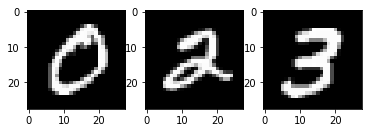

In [4]:
plt.figure(1)
plt.subplot(131)
plt.imshow(X_train[1,:,:], cmap='gray')
plt.subplot(132)
plt.imshow(X_train[5,:,:], cmap='gray')
plt.subplot(133)
plt.imshow(X_train[7,:,:], cmap='gray')
plt.show()

In [5]:
def coding_net(inputs, num_filter=32, num_interior=3):
    """Coding Net for Image to get interior points and moments"""
    regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)
    # Input Layer
    input_layer = tf.reshape(inputs, [-1,28,28,1])
    # First Convolution layer
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=num_filter,
        kernel_size=[5, 5],
        padding="same",
        kernel_regularizer=regularizer,
        activation=tf.nn.relu6)
    batch1 = tf.layers.batch_normalization(conv1,axis=1)
    pool1 = tf.layers.max_pooling2d(inputs=batch1, pool_size=[2, 2], strides=2)
    dropout1 = tf.layers.dropout(inputs=pool1, rate=0.7)
    
    # Second Convolution layer
    conv2 = tf.layers.conv2d(
        inputs=dropout1,
        filters=num_filter*2,
        kernel_size=[5, 5],
        padding="same",
        kernel_regularizer=regularizer,
        activation=tf.nn.relu6)
    batch2 = tf.layers.batch_normalization(conv2,axis=1)
    pool2 = tf.layers.max_pooling2d(inputs=batch2, pool_size=[2, 2], strides=2)
    dropout2 = tf.layers.dropout(inputs=pool2, rate=0.7)
    
    # Dense layer and outputs
    drop2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=drop2_flat, 
                            units=1024, 
                            kernel_regularizer=regularizer,
                            activation=tf.nn.relu6)
    dropout3 = tf.layers.dropout(inputs=dense, rate=0.7)
    
    loc = tf.layers.dense(inputs = dropout3, 
                          units = (num_interior+2)*2, 
                          activation = tf.nn.sigmoid)
    moment = tf.layers.dense(inputs = dropout3, 
                             units = (num_interior+2)*2)
    loc = tf.reshape(loc, [-1, num_interior+2, 2])
    moment = tf.reshape(moment, [-1, num_interior+2, 2])
    
    dense2 = tf.layers.dense(inputs=drop2_flat, 
                            units=512, 
                            kernel_regularizer=regularizer,
                            activation=tf.nn.relu6)
    dropout4 = tf.layers.dropout(inputs=dense2, rate=0.7)
    sig2 = tf.layers.dense(inputs = dropout4, 
                           units = 1)**2
    sig2 = tf.reshape(sig2, (-1,))
    
    return loc, moment, sig2

In [6]:
def reconstruction_xy(loc, moment, num_interior=3, num_points=30):
    """Using position and moments to reconstruct points on curve"""
    M = tf.constant([[1,0,0,0],[1,1,1,1],[0,1,0,0],[0,1,2,3]], 
                    dtype=tf.float64)
    M = tf.transpose(tf.linalg.inv(M))
    t_value = np.linspace(0,1, num = num_interior+2)
    
    tpoints = np.linspace(0, 1, num=num_points)
    basis = np.vstack([tpoints**0, tpoints**1, tpoints**2, tpoints**3])
    basis = tf.constant(basis, dtype=tf.float64)
    
    loc = tf.cast(loc, tf.float64); moment = tf.cast(moment, tf.float64)
    ### first interval
    i = 0
    
    x_i = tf.gather(loc, [i,i+1], axis=1)
    m_i = tf.gather(moment, [i,i+1], axis=1)
    xm_i = tf.concat([x_i, m_i], 1)
    
    coeff = tf.matmul(xm_i, M)
    curve = tf.matmul(coeff, basis)
    
    ### consequent intervals
    for i in range(1, num_interior+1):
        x_i = tf.gather(loc, [i,i+1], axis=1)
        m_i = tf.gather(moment, [i,i+1], axis=1)
        xm_i = tf.concat([x_i, m_i], 1)

        coeff_i = tf.matmul(xm_i, M)
        curve_i = tf.matmul(coeff_i, basis)
        
        coeff = tf.concat([coeff, coeff_i], 1)
        curve = tf.concat([curve, curve_i], 1)
    return curve, coeff

def reconstruction(loc, moment, num_interior=3, num_points=30):
    x_points, x_coeff = reconstruction_xy(loc[:,:,0], moment[:,:,0], num_interior, num_points)
    y_points, y_coeff = reconstruction_xy(loc[:,:,1], moment[:,:,1], num_interior, num_points)
    
    return x_points, y_points, x_coeff, y_coeff

In [7]:
index_tensor = np.zeros([28,28,2])
for i in range(28):
    for j in range(28):
        index_tensor[i,j,:] = [i/27.0, j/27.0]

def kernel_image(x_points, y_points, sig2):
    sig2 = tf.cast(sig2, tf.float64)
    locations = tf.constant(index_tensor, dtype=tf.float64)
    points = tf.stack([x_points, y_points], axis=2)
    dist = tf.einsum("iju,ntu->nijt", locations**2, tf.ones_like(points)) -\
           2 * tf.einsum("iju,ntu->nijt", locations, points) +\
           tf.einsum("iju,ntu->nijt", tf.ones_like(locations), points**2)
    kernel = tf.exp(-0.5*tf.einsum("nijt,n->nijt", dist, sig2**(-1)))
    images = tf.reduce_sum(kernel, axis=3)
    images = tf.tanh(images)
    images = tf.cast(images, tf.float64)
    
    return images

def loss(kernel_img, images):
    images = tf.cast(images, tf.float64)
    return tf.reduce_mean( (kernel_img - images)**2 )

In [8]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 28, 28])
Images = tf.placeholder(tf.float32, [None, 28, 28])
learning_rate = tf.placeholder(tf.float32, shape=[])

num_interior = 3; num_points = 20

loc, moment, sig2 = coding_net(X, num_interior = num_interior)
x_points, y_points, _, _ = reconstruction(loc, moment, num_interior, num_points)

reg = 1; lam_sep = 2e-5; lam_len = 1e-4; lam_smooth = 1e-4

totalp = (num_interior+1)*num_points

kernel_imgs = kernel_image(x_points,y_points, sig2=sig2)
total_loss = loss(kernel_imgs,Images)

xdiff = x_points[:,1:totalp] - x_points[:,:(totalp-1)]
ydiff = y_points[:,1:totalp] - y_points[:,:(totalp-1)]
loc_xdiff = loc[:,1:(num_interior+2),0] - loc[:,:(num_interior+1),0]
loc_ydiff = loc[:,1:(num_interior+2),1] - loc[:,:(num_interior+1),1]

eps = 1e-8
length_penalty = tf.reduce_mean(
                    tf.reduce_sum(
                        tf.sqrt(
                            tf.clip_by_value(xdiff**2 + ydiff**2, eps, 1)
                        ),
                        axis = 1
                    )
                 )

sep_penalty = -tf.reduce_mean(
                    tf.reduce_sum(
                        tf.sqrt(loc_xdiff**2 + loc_ydiff**2),
                        axis = 1
                    )
                 )

smooth_penalty = tf.reduce_mean((
                    moment[:,1:(num_interior+2),:] - moment[:,:(num_interior+1),:]
                 )**2)

total_loss = tf.cast(total_loss, tf.float64) + \
             reg * tf.cast(tf.losses.get_regularization_loss(), tf.float64) +\
             lam_sep * tf.cast(sep_penalty, tf.float64) +\
             lam_len * tf.cast(length_penalty, tf.float64) +\
             lam_smooth * tf.cast(smooth_penalty, tf.float64) + \
            1e-2 * tf.cast(tf.reduce_mean(sig2), tf.float64)
            
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(total_loss)

AttributeError: module 'tensorflow.compat.v1' has no attribute 'contrib'

Training
Iteration 0: with minibatch training loss = 1.37 val loss = 2.07
Sigma2: 2.3904  Sigma2: 2.1369  Sigma2: 2.0967


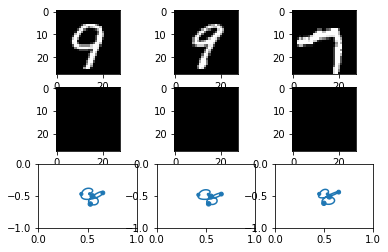

Iteration 200: with minibatch training loss = 0.131 val loss = 0.132
Sigma2: 0.0012998  Sigma2: 0.00092753  Sigma2: 0.00066593


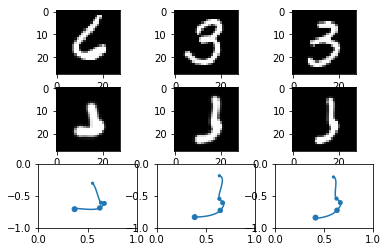

Iteration 400: with minibatch training loss = 0.0701 val loss = 0.0715
Sigma2: 0.00052261  Sigma2: 0.0009439  Sigma2: 0.00065


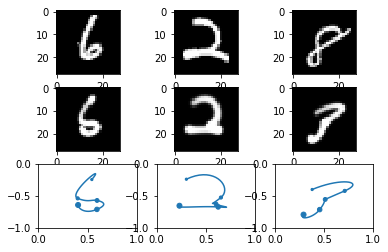

Iteration 600: with minibatch training loss = 0.0582 val loss = 0.0588
Sigma2: 0.00068119  Sigma2: 0.00033881  Sigma2: 0.001006


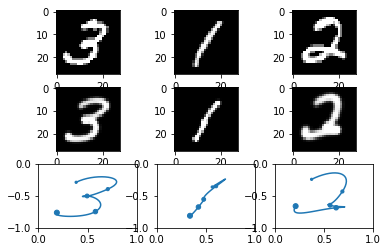

Iteration 800: with minibatch training loss = 0.0511 val loss = 0.0473
Sigma2: 0.00041399  Sigma2: 0.00058158  Sigma2: 0.0009882


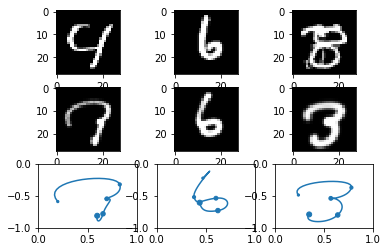

Epoch 1, Overall loss = 0.131
Learning Rate: 0.0001


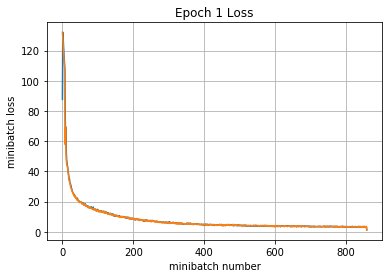

Iteration 1000: with minibatch training loss = 0.0495 val loss = 0.0487
Sigma2: 0.00034421  Sigma2: 0.00052955  Sigma2: 0.00098261


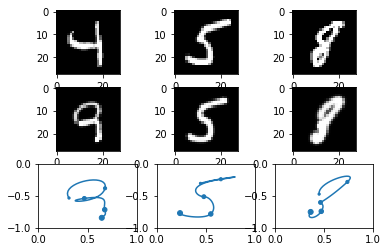

Iteration 1200: with minibatch training loss = 0.047 val loss = 0.0519
Sigma2: 0.00033702  Sigma2: 0.00044155  Sigma2: 0.00031418


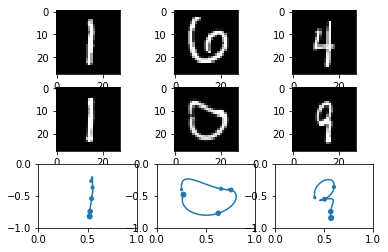

Iteration 1400: with minibatch training loss = 0.0447 val loss = 0.045
Sigma2: 0.00077186  Sigma2: 0.00038978  Sigma2: 0.0010042


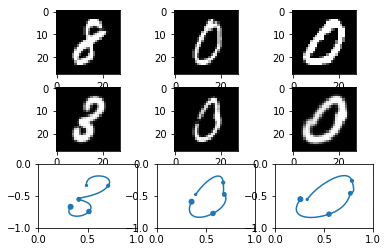

Iteration 1600: with minibatch training loss = 0.0453 val loss = 0.0425
Sigma2: 0.0018464  Sigma2: 0.00064746  Sigma2: 0.00046741


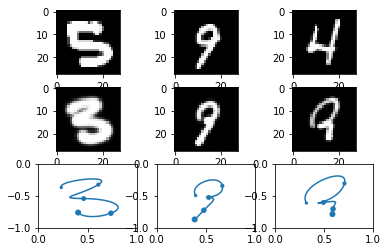

Epoch 2, Overall loss = 0.046


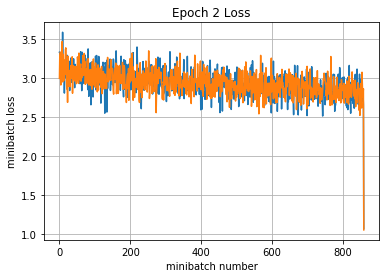

Iteration 1800: with minibatch training loss = 0.0408 val loss = 0.0432
Sigma2: 0.00056891  Sigma2: 0.00051837  Sigma2: 0.00099779


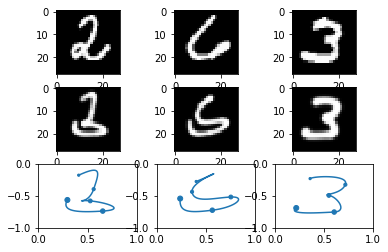

Iteration 2000: with minibatch training loss = 0.0447 val loss = 0.041
Sigma2: 0.0014483  Sigma2: 0.00061442  Sigma2: 0.00096742


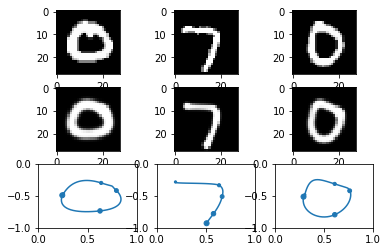

Iteration 2200: with minibatch training loss = 0.0447 val loss = 0.0433
Sigma2: 0.00094163  Sigma2: 0.00034291  Sigma2: 0.00097134


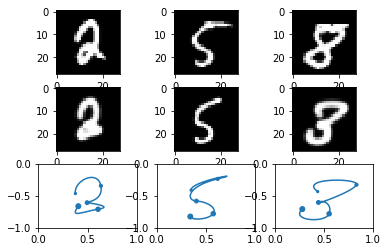

Iteration 2400: with minibatch training loss = 0.0415 val loss = 0.0423
Sigma2: 0.00017021  Sigma2: 0.00094096  Sigma2: 0.00080767


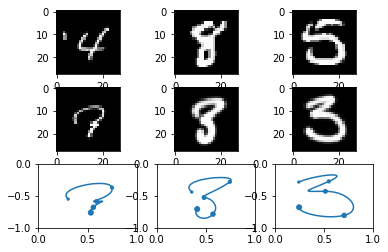

Epoch 3, Overall loss = 0.0429


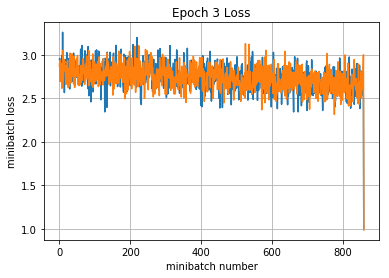

Iteration 2600: with minibatch training loss = 0.0434 val loss = 0.0403
Sigma2: 0.00039849  Sigma2: 0.00051013  Sigma2: 0.00034001


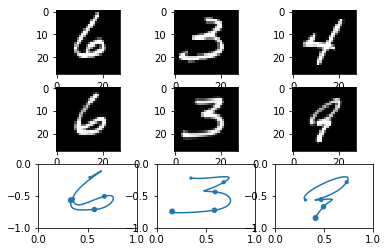

Iteration 2800: with minibatch training loss = 0.0447 val loss = 0.0379
Sigma2: 0.00056806  Sigma2: 0.00030561  Sigma2: 0.0011623


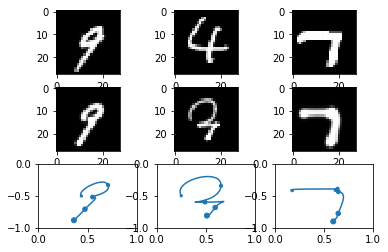

Iteration 3000: with minibatch training loss = 0.0404 val loss = 0.0406
Sigma2: 0.00051032  Sigma2: 0.0007663  Sigma2: 0.00041385


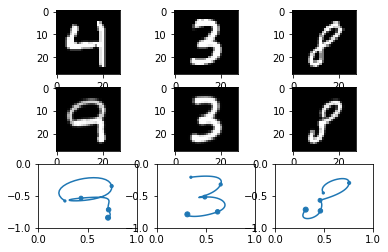

Iteration 3200: with minibatch training loss = 0.0417 val loss = 0.0394
Sigma2: 0.0010269  Sigma2: 0.0003898  Sigma2: 0.00087288


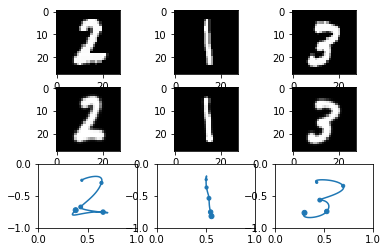

Iteration 3400: with minibatch training loss = 0.0408 val loss = 0.0411
Sigma2: 0.0011075  Sigma2: 0.00089353  Sigma2: 0.00071309


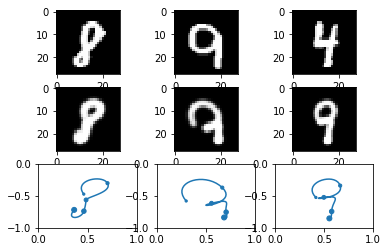

Epoch 4, Overall loss = 0.0405


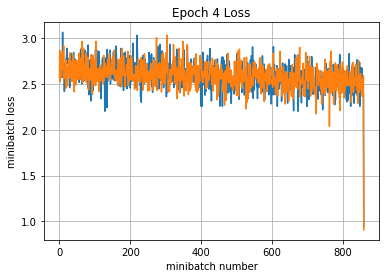

Iteration 3600: with minibatch training loss = 0.0432 val loss = 0.0368
Sigma2: 0.00033606  Sigma2: 0.00032613  Sigma2: 0.00091899


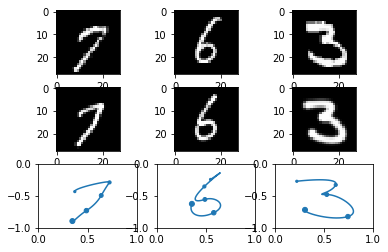

Iteration 3800: with minibatch training loss = 0.0377 val loss = 0.0409
Sigma2: 0.00084557  Sigma2: 0.00049503  Sigma2: 0.00050423


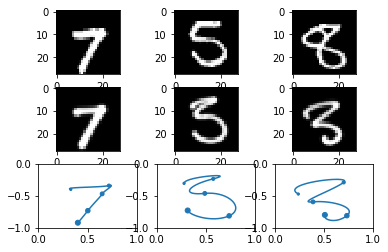

Iteration 4000: with minibatch training loss = 0.0395 val loss = 0.0379
Sigma2: 0.00076205  Sigma2: 0.00098204  Sigma2: 0.00061989


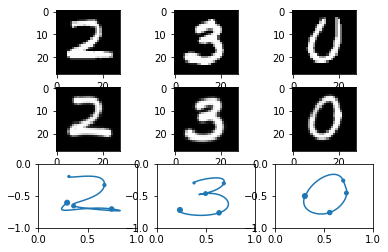

Iteration 4200: with minibatch training loss = 0.0382 val loss = 0.0369
Sigma2: 0.00048191  Sigma2: 0.00059536  Sigma2: 0.0017188


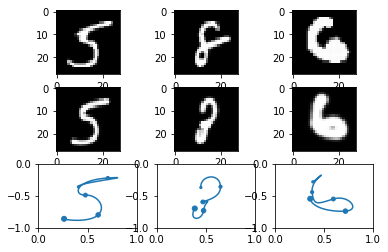

Epoch 5, Overall loss = 0.0387


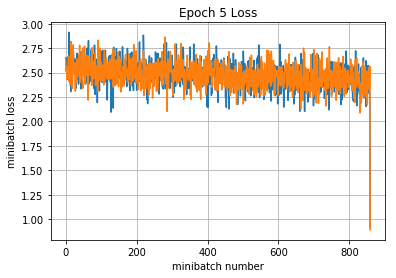

Iteration 4400: with minibatch training loss = 0.037 val loss = 0.0398
Sigma2: 0.00072431  Sigma2: 0.00078164  Sigma2: 0.0009055


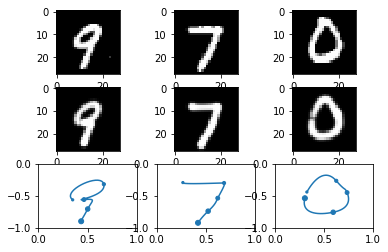

Iteration 4600: with minibatch training loss = 0.0402 val loss = 0.0404
Sigma2: 0.00071817  Sigma2: 0.00032334  Sigma2: 0.00047932


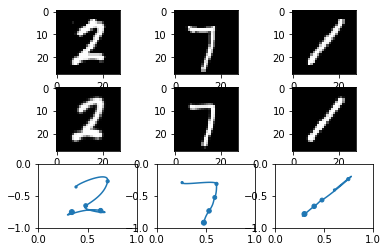

Iteration 4800: with minibatch training loss = 0.0352 val loss = 0.0325
Sigma2: 0.00098979  Sigma2: 0.00065739  Sigma2: 0.00048482


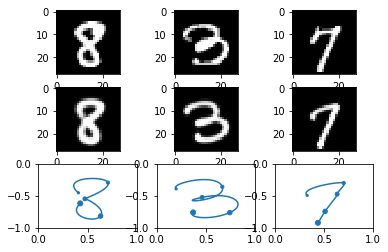

Iteration 5000: with minibatch training loss = 0.0358 val loss = 0.0376
Sigma2: 0.00053807  Sigma2: 0.00049857  Sigma2: 0.00050012


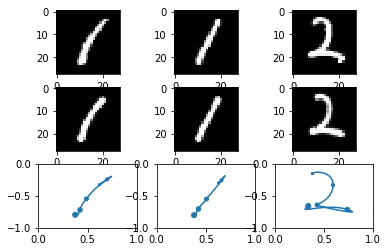

Epoch 6, Overall loss = 0.0373


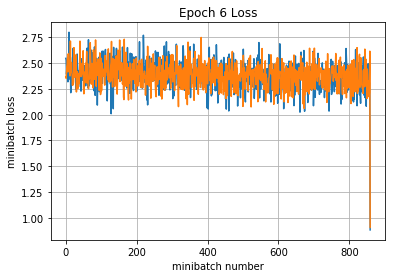

Iteration 5200: with minibatch training loss = 0.0394 val loss = 0.039
Sigma2: 0.00049616  Sigma2: 0.00041923  Sigma2: 0.0004486


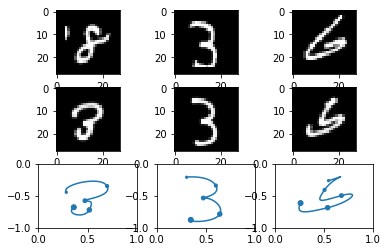

Iteration 5400: with minibatch training loss = 0.0364 val loss = 0.0365
Sigma2: 0.00092166  Sigma2: 0.00058528  Sigma2: 0.00035319


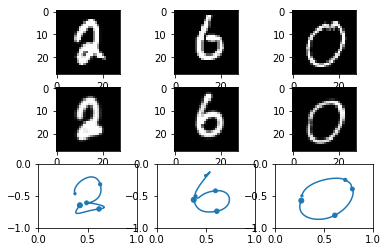

Iteration 5600: with minibatch training loss = 0.0357 val loss = 0.0341
Sigma2: 0.00062776  Sigma2: 0.0006497  Sigma2: 0.0005621


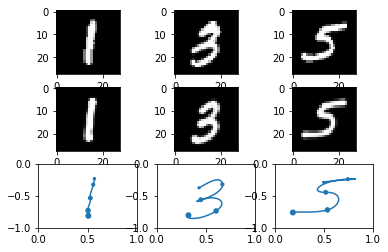

Iteration 5800: with minibatch training loss = 0.0352 val loss = 0.0347
Sigma2: 0.00026645  Sigma2: 0.00069172  Sigma2: 0.0010539


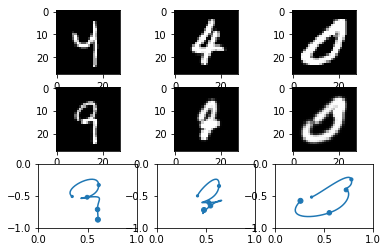

Iteration 6000: with minibatch training loss = 0.0391 val loss = 0.038
Sigma2: 0.00064425  Sigma2: 0.00094126  Sigma2: 0.00060101


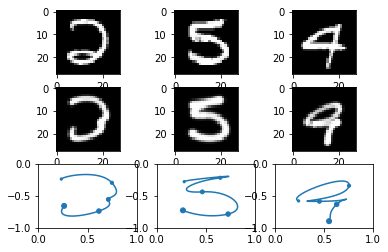

Epoch 7, Overall loss = 0.0362


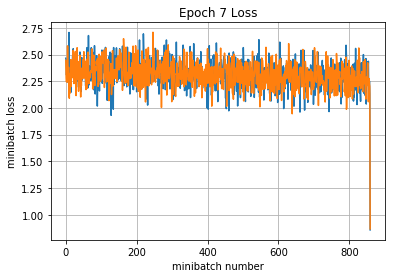

Iteration 6200: with minibatch training loss = 0.0334 val loss = 0.0407
Sigma2: 0.00066695  Sigma2: 0.0010176  Sigma2: 0.00041908


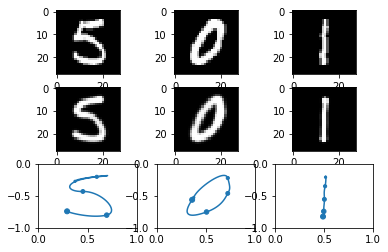

Iteration 6400: with minibatch training loss = 0.0343 val loss = 0.0382
Sigma2: 0.0005268  Sigma2: 0.00076766  Sigma2: 0.00064912


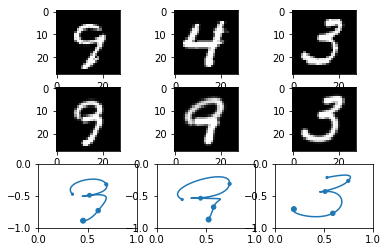

Iteration 6600: with minibatch training loss = 0.0346 val loss = 0.0339
Sigma2: 0.00046542  Sigma2: 0.00070566  Sigma2: 0.00078139


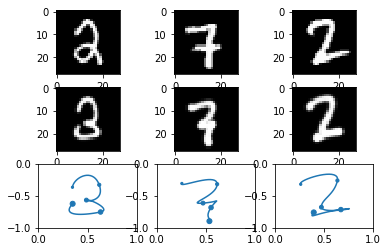

Iteration 6800: with minibatch training loss = 0.0358 val loss = 0.0367
Sigma2: 0.00067493  Sigma2: 0.00040238  Sigma2: 0.00036033


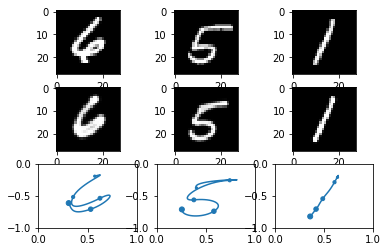

Epoch 8, Overall loss = 0.0354


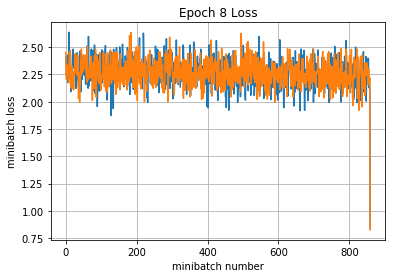

Iteration 7000: with minibatch training loss = 0.0346 val loss = 0.0351
Sigma2: 0.00083756  Sigma2: 0.00060792  Sigma2: 0.00077925


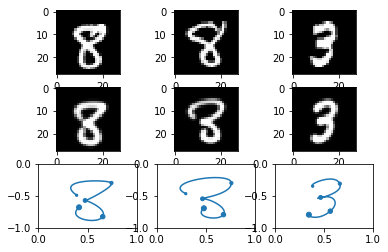

Iteration 7200: with minibatch training loss = 0.0356 val loss = 0.0345
Sigma2: 0.001333  Sigma2: 0.00045764  Sigma2: 0.00029961


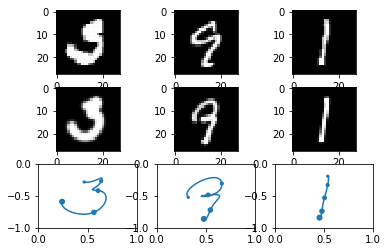

Iteration 7400: with minibatch training loss = 0.0341 val loss = 0.0352
Sigma2: 0.000503  Sigma2: 0.00056896  Sigma2: 0.00061242


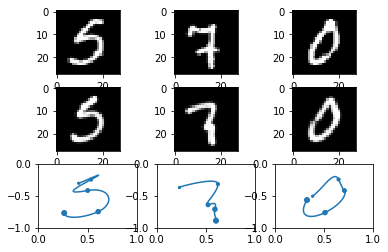

Iteration 7600: with minibatch training loss = 0.0325 val loss = 0.0325
Sigma2: 0.00071211  Sigma2: 0.0003641  Sigma2: 0.0010669


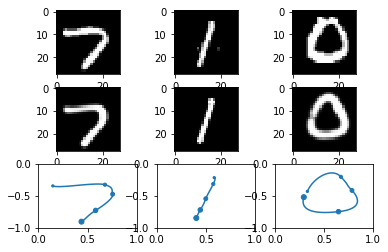

Epoch 9, Overall loss = 0.0347


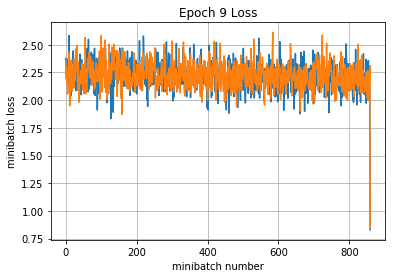

Iteration 7800: with minibatch training loss = 0.0379 val loss = 0.0359
Sigma2: 0.00052662  Sigma2: 0.00043076  Sigma2: 0.0014995


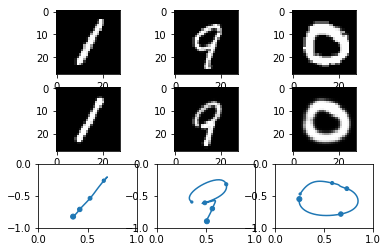

Iteration 8000: with minibatch training loss = 0.0373 val loss = 0.0356
Sigma2: 0.00049983  Sigma2: 0.0012992  Sigma2: 0.00051751


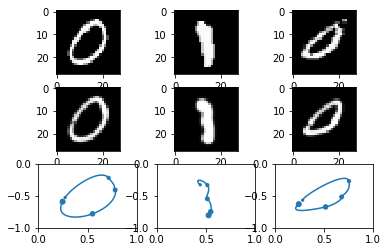

Iteration 8200: with minibatch training loss = 0.029 val loss = 0.0333
Sigma2: 0.0010416  Sigma2: 0.0007429  Sigma2: 0.00045214


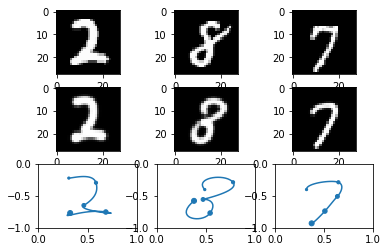

Iteration 8400: with minibatch training loss = 0.031 val loss = 0.0336
Sigma2: 0.00059516  Sigma2: 0.00053419  Sigma2: 0.00046543


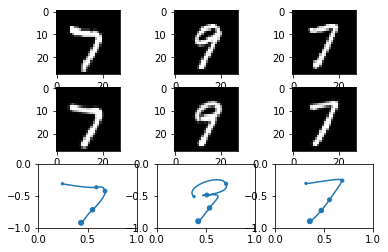

Epoch 10, Overall loss = 0.0342


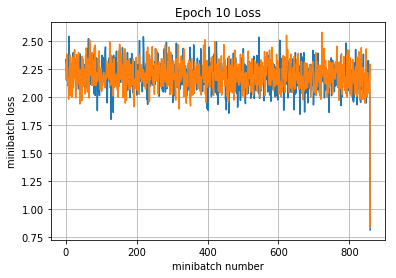

In [9]:
def run_model(session, total_loss, train_step, Xd, Xval, lr, 
              epochs=5, batch_size=64, print_every=100,
              plot_losses=True):

    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)    
    
    iter_cnt = 0
    fig = 1
    for e in range(epochs):
        losses = []
        val_losses = []
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            feed_dict = {X: Xd[idx,:,:],
                         Images: Xd[idx,:,:]}

            actual_batch_size = Xd[idx,:,:].shape[0]
            
            loss = session.run(total_loss, feed_dict=feed_dict)
            session.run(train_step, {X: Xd[idx,:,:],
                                     Images: Xd[idx,:,:],
                                     learning_rate: lr})
            
            ri = np.random.randint(0,5000,size=batch_size)
            val_dict = {X: Xval[ri,:,:],
                        Images: Xval[ri,:,:]}
            val_loss = session.run(total_loss, val_dict)
            
            losses.append(loss*actual_batch_size)
            val_losses.append(val_loss*actual_batch_size)
            
            # print every now and then
            if (iter_cnt % print_every) == 0:
                
                print("Iteration {0}: with minibatch training loss = {1:.3g} val loss = {2:.3g}"\
                      .format(iter_cnt,loss, val_loss))
                
                ### show img
                val_ind = np.random.randint(0,5000,size=3)
                
                feed_dict_val = {X: Xval[val_ind,:,:],
                                 Images: Xval[val_ind,:,:]}
                
                locations = session.run(loc, feed_dict_val)
                xpo, ypo = session.run([x_points, y_points], feed_dict_val)
                sig2_val = session.run(sig2, feed_dict_val)
                kimgs_val = session.run(kernel_imgs, feed_dict_val) 
                
                print("Sigma2: {0:.5g}  Sigma2: {1:.5g}  Sigma2: {2:.5g}"\
                      .format(sig2_val[0],sig2_val[1],sig2_val[2]))
                show_img(fig, Xval[val_ind,:,:], kimgs_val, locations, xpo,ypo)
                fig += 1
                plt.show()
                
            iter_cnt += 1
        mean_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {1}, Overall loss = {0:.3g}"\
              .format(mean_loss,e+1))
        if e % 10 == 0:
            lr /= 10
            print("Learning Rate: {0:.3g}".format(lr))
        if plot_losses:
            plt.plot(losses,label='Train Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return mean_loss

sess = tf.Session()
with tf.device("/gpu:0"):
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess, total_loss, train_step, X_train,X_val, 1e-3, 10,64,200, True)
    
    
###########################################################################
##
##  See the training result below
##  First line is true digit picture from validation set
##  Second line is reconstruction map from curve fitting
##  Third line is curve plot
##
##  After 1000 iteration the result should be fine
##  But it will struggle with some digits, say 4 or 5
##  
############################################################################

In [30]:
###################################################
##
##  Now let's see can it generalize well to 
##  Handwritten Letters, which should be  
##  totally different from digit
##  You should see it's struggling and behave
##  like using a digit to approximate the letter
##  But for those simple letter results looks good
##
###################################################


letter = np.load("letter_data.npy")
test_ind = np.random.randint(0,10000,size=3)
                
feed_dict_test = {X: letter[test_ind,:,:],
                 Images: letter[test_ind,:,:]}

locations = sess.run(loc, feed_dict_test)
xpo, ypo = sess.run([x_points, y_points], feed_dict_test)
kimgs_test = sess.run(kernel_imgs, feed_dict_test) 

show_img(1, letter[test_ind,:,:],kimgs_test,locations,xpo,ypo)
plt.show()

test_ind = np.random.randint(0,10000,size=3)
                
feed_dict_test = {X: letter[test_ind,:,:],
                 Images: letter[test_ind,:,:]}

locations = sess.run(loc, feed_dict_test)
xpo, ypo = sess.run([x_points, y_points], feed_dict_test)
kimgs_test = sess.run(kernel_imgs, feed_dict_test) 

show_img(1, letter[test_ind,:,:],kimgs_test,locations,xpo,ypo)
plt.show()

test_ind = np.random.randint(0,10000,size=3)
                
feed_dict_test = {X: letter[test_ind,:,:],
                 Images: letter[test_ind,:,:]}

locations = sess.run(loc, feed_dict_test)
xpo, ypo = sess.run([x_points, y_points], feed_dict_test)
kimgs_test = sess.run(kernel_imgs, feed_dict_test) 

show_img(1, letter[test_ind,:,:],kimgs_test,locations,xpo,ypo)
plt.show()

(10000, 28, 28)

In [9]:
def show_img2(fig, image, kimg, xpo, ypo):
    plt.figure(fig)
    
    plt.subplot(1,3,1)
    plt.imshow(image[0,:,:], cmap='gray')
    
    plt.subplot(1,3,2)
    plt.imshow(kimg[0,:,:], cmap='gray')
    
    plt.subplot(1,3,3)
    xi = xpo[0,:]; yi = ypo[0,:]; t = len(xi)
    loc_x = xpo[0,::20]; loc_y = ypo[0,::20]
    n = loc_x.shape[0]
    s = np.linspace(25, 5, num=n)
    plt.plot(yi, -xi)
    plt.scatter(loc_y, -loc_x, s=s)
    plt.xlim(0,1); plt.ylim(-1,0)
    return

(1, 100, 100)


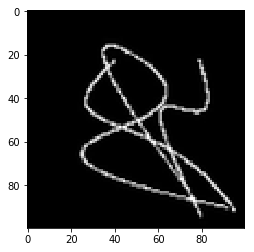

In [31]:
from PIL import Image
test = Image.open("test.png")
img = test.resize((100,100), Image.ANTIALIAS)
imgM = np.asarray(img.convert('L'))
imgM = imgM/np.max(imgM)
imgM.resize([1,100,100])
print(imgM.shape)
plt.imshow(imgM[0,:,:], cmap='gray')
plt.show()

Training
Iteration 0: with minibatch training loss = 1.28 length = 0.643
Sigma2: 1.3323


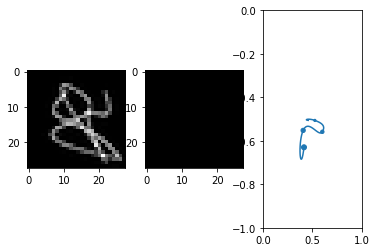

Iteration 400: with minibatch training loss = 0.0771 length = 0.921
Sigma2: 0.0002092


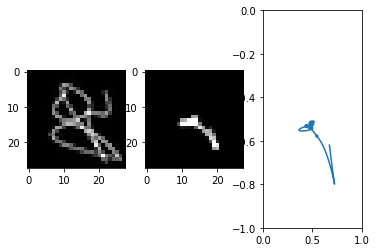

Iteration 800: with minibatch training loss = 0.0508 length = 1.01
Sigma2: 0.00013945


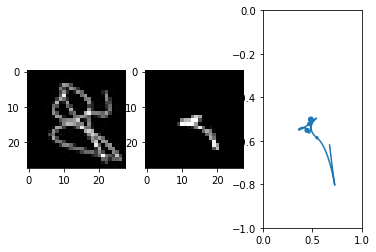

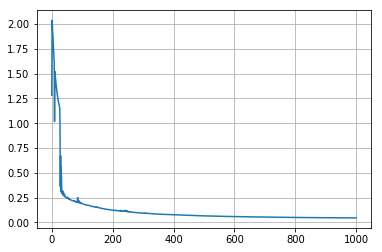

Iteration 1200: with minibatch training loss = 0.0434 length = 1.02
Sigma2: 0.00013658


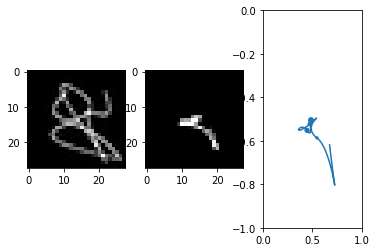

Iteration 1600: with minibatch training loss = 0.04 length = 1.02
Sigma2: 0.00012615


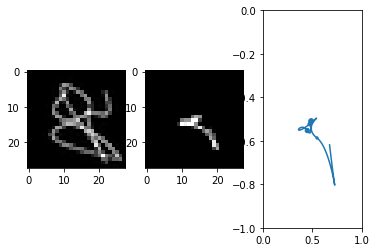

In [29]:
def run_model(session, total_loss, train_step, test, lr, 
              max_iter=2000, print_every=100,
              plot_losses=True):

    X_train = test
    
    iter_cnt = 0
    fig = 1
    losses = []
    lengthes = []
    for i in range(max_iter):
      
        feed_dict = {X: X_train,
                     Images: X_train}

        loss = session.run(total_loss, feed_dict=feed_dict)
        session.run(train_step, {X: X_train,
                                 Images: X_train,
                                 learning_rate: lr})

        length = session.run(length_penalty, feed_dict)

        losses.append(loss)
        lengthes.append(length)

        # print every now and then
        if (iter_cnt % print_every) == 0:

            print("Iteration {0}: with minibatch training loss = {1:.3g} length = {2:.3g}"\
                  .format(iter_cnt,loss, length))

            ### show img

            xpo, ypo = session.run([x_points, y_points], feed_dict)
            sigma2 = session.run(sig2, feed_dict)
            kimg = session.run(kernel_imgs, feed_dict) 

            print("Sigma2: {0:.5g}"
                  .format(sigma2[0]))
            show_img2(fig, X_train, kimg, xpo,ypo)
            fig += 1
            plt.show()

        iter_cnt += 1
        mean_loss = np.mean(losses)
        if i != 0 and i % (1000) == 0 and plot_losses:
            plt.plot(np.array(losses)[i-1000:i+1])
            plt.grid(True)
            plt.show()
    return mean_loss

sess = tf.Session()
with tf.device("/gpu:0"):
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess, total_loss, train_step, imgM, 1e-3, 2000,400, True)